# Stock Price Prediction

Useful features for stock price predictions:

- Correlated Assets: external factors such as competitors, global economy, geopolitical situation, etc.

- Technical Indicators: moving average, exponential moving average, momentum, etc.

- Fundamental Analysis: 

    1. Performance Reports: annual, quarterly Reports
    2. News: news about upcoming events that can potentially move the stock price

## Predicting weekly return of Microsoft stock. Features to be used:

- correlated assets: 

    1. Stocks of IBM, Alphabet

    2. Currency

    3. Indices

In [95]:
from typing import List, Sequence, Tuple, Union

In [2]:
# Importing Models
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
# Importing Training pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [4]:
# deep learning models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [5]:
# statsmodels
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [6]:
# data analysis tools
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [7]:
stk_tickers = ["MSFT", "IBM", "GOOGL"]
ccy_tickers = ["DEXJPUS", "DEXUSUK"]
idx_tickers = ["SP500", "DJIA", "VIXCLS"]

stk_data = web.DataReader(stk_tickers, "yahoo")
ccy_data = web.DataReader(ccy_tickers, "fred")
idx_data = web.DataReader(idx_tickers, "fred")

Since the number of trading days in a week is 5, we'll compute the return of MSFT stocks using 5 trading days.

In [21]:
return_period = 5
# lag 5 days, differencing and log transform data
Y = np.log(stk_data.loc[:, ("Adj Close", "MSFT")]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+"_pred"
X1 = np.log(stk_data.loc[:, ("Adj Close", ("GOOGL", "IBM"))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ("Adj Close", "MSFT")]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ["MSFT_DT", "MSFT_3DT", "MSFT_6DT", "MSFT_12DT"]
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]


### Exploratory Analysis

<AxesSubplot:title={'center':'Correlation Matrix'}>

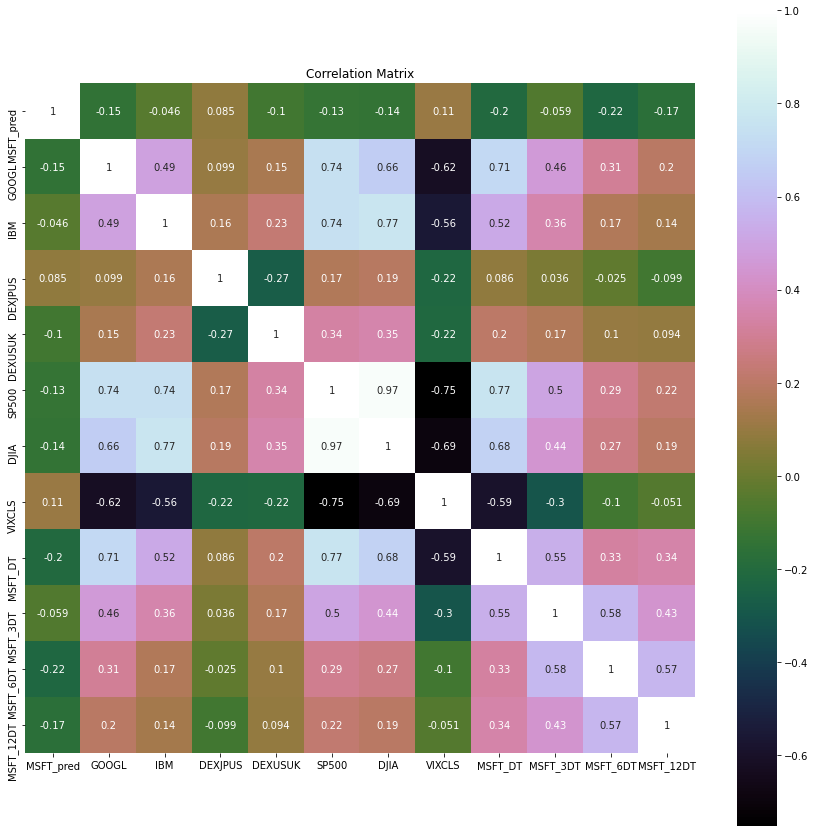

In [23]:
correlation = dataset.corr()
plt.figure(figsize=(15, 15))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="cubehelix")

<Figure size 1080x1080 with 0 Axes>

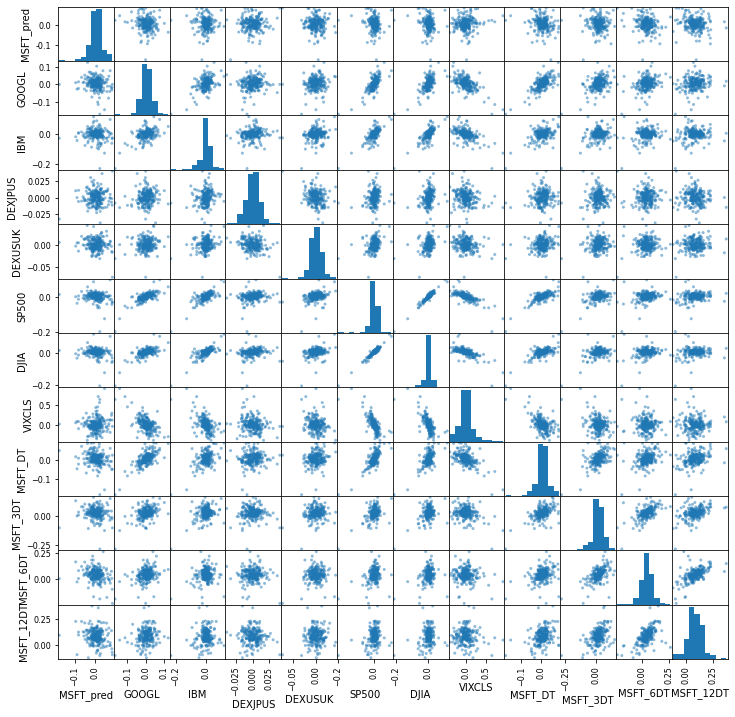

In [24]:
plt.figure(figsize=(15, 15))
scatter_matrix(dataset, figsize=(12, 12))
plt.show()

### Time Series Analysis

<ipython-input-25-4b20d1ee5896>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(Y, freq=52)


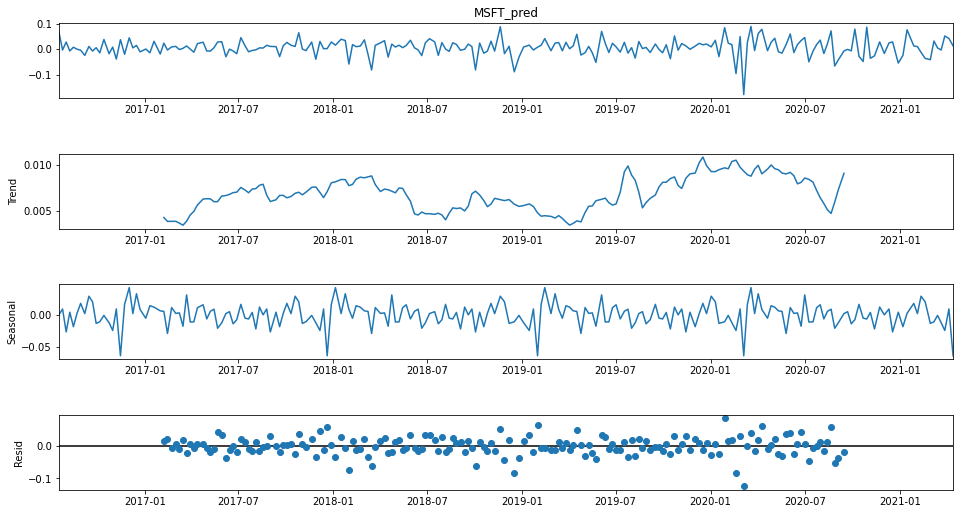

In [25]:
res = sm.tsa.seasonal_decompose(Y, freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [26]:
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:]

In [27]:
num_folds = 10
scoring = "neg_mean_squared_error"

In [28]:
models = []
models.append(("LR", LinearRegression()))
models.append(("LASSO", Lasso()))
models.append(("EN", ElasticNet()))
models.append(("KNN", KNeighborsRegressor()))
models.append(("CART", DecisionTreeRegressor()))
models.append(("SVR", SVR()))
models.append(("MLP", MLPRegressor()))
models.append(("ABR", AdaBoostRegressor()))
models.append(("GBR", GradientBoostingRegressor()))
models.append(("RFR", RandomForestRegressor()))
models.append(("ETR", ExtraTreesRegressor()))


In [35]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    ## k-fold analysis:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    # converted mean squared error to positive. the lower the better
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    # Full training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

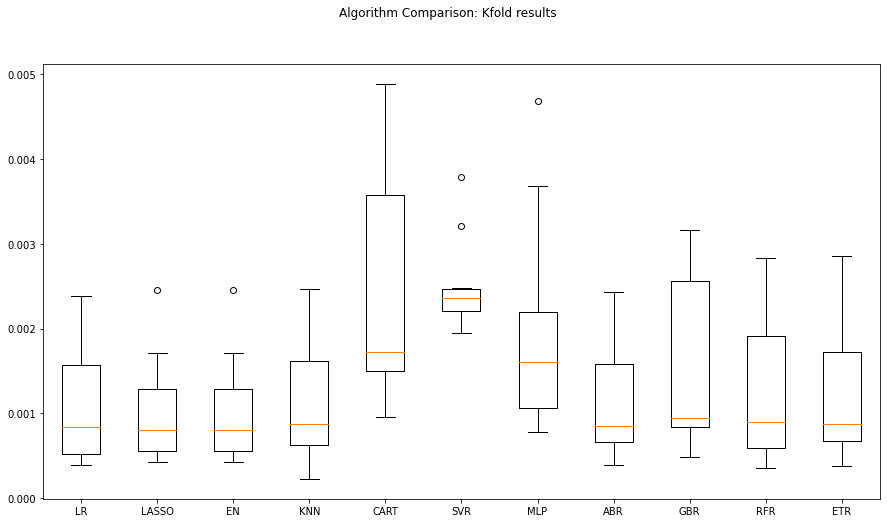

In [36]:
fig = plt.figure()
fig.suptitle("Algorithm Comparison: Kfold results")
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.show()

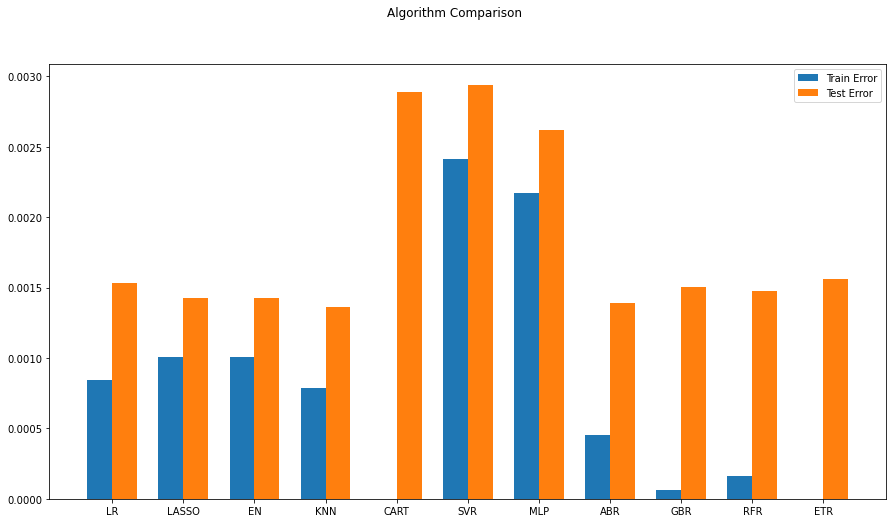

In [39]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

The kfold results and train/test errors show that LASSO and Elasticnet perform the best. I'll pick LASSO as it requires fewer parameters to train

## Time Series_based models

### ARIMA

In [40]:
X_train_ARIMA = X_train.loc[:, ["GOOGL", "IBM", "DEXJPUS", "SP500", "DJIA", "VIXCLS"]]
X_test_ARIMA = X_test.loc[:, ["GOOGL", "IBM", "DEXJPUS", "SP500", "DJIA", "VIXCLS"]]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

In [41]:
modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1, 0, 0])
model_fit = modelARIMA.fit()

/home/tnguyen2921/miniconda3/envs/fin-ml/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/tnguyen2921/miniconda3/envs/fin-ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index h

In [42]:
error_training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start=tr_len - 1, end=to_len - 1,
                exog=X_test_ARIMA)[1:]
error_test_ARIMA = mean_squared_error(Y_test, predicted)
error_test_ARIMA

/home/tnguyen2921/miniconda3/envs/fin-ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


0.0014638396256809322

In [50]:
seq_len = 2
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len,:]

In [53]:
X_train_LSTM.shape, X_test_LSTM.shape, Y_train_LSTM.shape

((179, 2, 11), (45, 2, 11), (179,))

In [54]:
def create_LSTMmodel(learn_rate = 0.01, momentum=0):
    model = Sequential([
        LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])),
        Dense(1)
    ])
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss="mse", optimizer=optimizer)
    return model
LSTMModel = create_LSTMmodel(learn_rate=0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM), epochs=330, batch_size=72, shuffle=False)

============================] - 0s 143ms/step - loss: 8.2251e-04 - val_loss: 0.0015
Epoch 140/330
3/3 [==============================] - 0s 141ms/step - loss: 8.2248e-04 - val_loss: 0.0015
Epoch 141/330
3/3 [==============================] - 0s 75ms/step - loss: 8.2246e-04 - val_loss: 0.0015
Epoch 142/330
3/3 [==============================] - 0s 101ms/step - loss: 8.2243e-04 - val_loss: 0.0015
Epoch 143/330
3/3 [==============================] - 0s 84ms/step - loss: 8.2241e-04 - val_loss: 0.0015
Epoch 144/330
3/3 [==============================] - 0s 82ms/step - loss: 8.2238e-04 - val_loss: 0.0015
Epoch 145/330
3/3 [==============================] - 0s 95ms/step - loss: 8.2236e-04 - val_loss: 0.0015
Epoch 146/330
3/3 [==============================] - 0s 90ms/step - loss: 8.2233e-04 - val_loss: 0.0015
Epoch 147/330
3/3 [==============================] - 0s 73ms/step - loss: 8.2231e-04 - val_loss: 0.0015
Epoch 148/330
3/3 [==============================] - 0s 82ms/step - loss: 8.2228e-

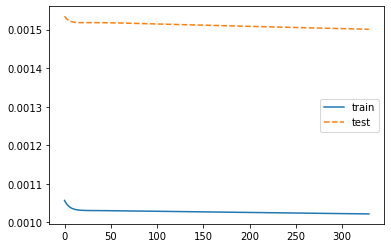

In [55]:
plt.plot(LSTMModel_fit.history["loss"], label="train")
plt.plot(LSTMModel_fit.history["val_loss"], "--", label="test")
plt.legend()
plt.show()

In [56]:
error_training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test, predicted)

In [72]:
len(train_results), len(test_results)

(14, 17)

In [80]:
train_results = train_results[:-3]

In [79]:
test_results = test_results[:11]

In [81]:
test_results.append(error_test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_training_ARIMA)
train_results.append(error_training_LSTM)

names.append("ARIMA")
names.append("LSTM")

In [82]:
len(train_results), len(ind)

(13, 14)

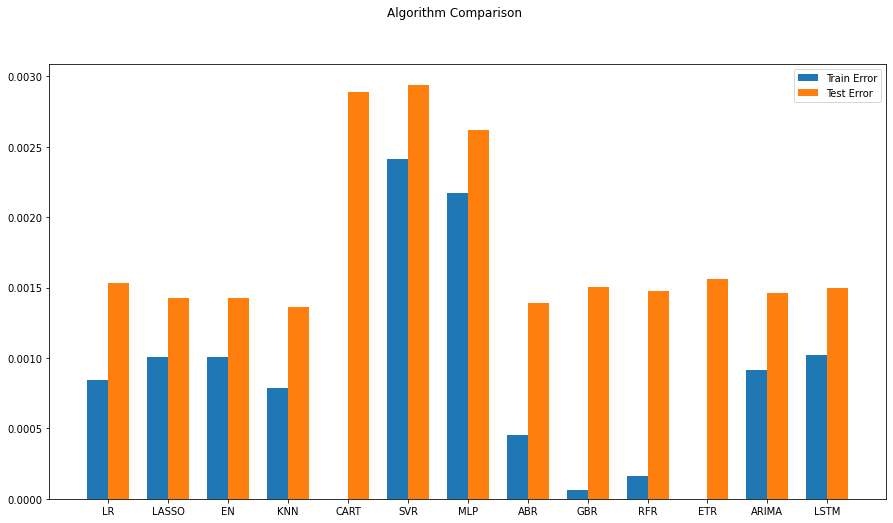

In [94]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names + ["ARIMA", "LSTM"]))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names+["ARIMA", "LSTM"])
plt.show()

Of the two time-series based models, ARIMA performes better

In [96]:
import warnings
def evaluate_arima_model(arima_order: Sequence[int]) -> float:
    modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values: Sequence[int], d_values: Sequence[int], q_values: Sequence[int]):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f"ARIMA {order}, MSE={mse:.7f}")
                except:
                    continue
    print(f"Best ARIMA {best_cfg}, MSE={best_score:.7f}")
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)



ARIMA (0, 0, 0), MSE=0.0009695
ARIMA (0, 0, 1), MSE=0.0009197
ARIMA (1, 0, 0), MSE=0.0009176
ARIMA (1, 0, 1), MSE=0.0009166
ARIMA (2, 0, 0), MSE=0.0009168
ARIMA (2, 0, 1), MSE=0.0008675
Best ARIMA (2, 0, 1), MSE=0.0008675


Finalize the model

In [97]:
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[2, 0, 1])
model_fit_tuned = modelARIMA_tuned.fit()

In [98]:
predicted_tuned = model_fit.predict(start=tr_len - 1, end=to_len-1, exog=X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))

0.0014638396256809322


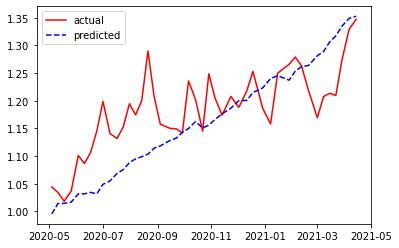

In [99]:
predicted_tuned.index = Y_test.index
plt.plot(np.exp(Y_test).cumprod(), "r", label="actual")
plt.plot(np.exp(predicted_tuned).cumprod(), "b--", label="predicted")
plt.legend()
plt.rcParams["figure.figsize"] = (8, 5)
plt.show()

The model was able to capture the trend of the stock. However, it was not able to match the stock movement.

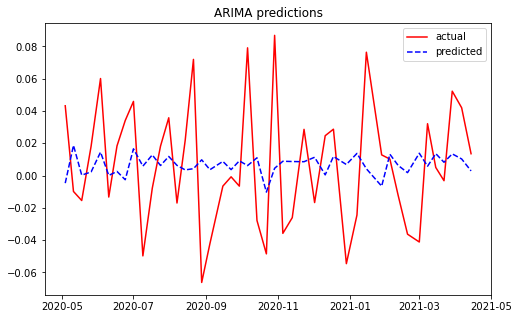

In [108]:
plt.plot(Y_test, "r", label="actual")
plt.plot(predicted_tuned, "b--", label="predicted")
plt.title("ARIMA predictions")
plt.legend()
plt.show()

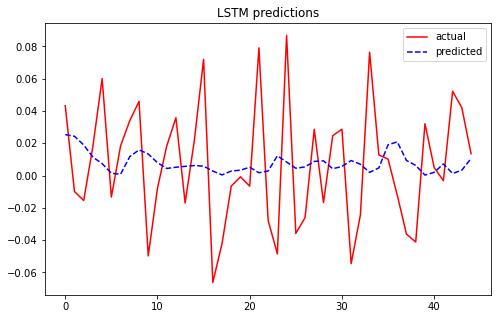

In [107]:
lstm_preds = LSTMModel.predict(X_test_LSTM)
plt.plot(Y_test_LSTM, "r", label="actual")
plt.plot(lstm_preds, "b--", label="predicted")
plt.title("LSTM predictions")
plt.legend()
plt.show()